<h2>Quick Start: Creating Sample-wise Unlearnable Examples</h2>

<h3>Prepare Data</h3>

In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Prepare Dataset
train_transform = [
    transforms.ToTensor()
]
test_transform = [
    transforms.ToTensor()
]
train_transform = transforms.Compose(train_transform)
test_transform = transforms.Compose(test_transform)

clean_train_dataset = datasets.CIFAR10(root='./data1/mjli/Code/kerdeq/data/', train=True, download=True, transform=train_transform)
clean_test_dataset = datasets.CIFAR10(root='./data1/mjli/Code/kerdeq/data/', train=False, download=True, transform=test_transform)

### No shuffle, easy to perturb image
clean_train_loader = DataLoader(dataset=clean_train_dataset, batch_size=512,
                                shuffle=False, pin_memory=True,
                                drop_last=False, num_workers=6)
clean_test_loader = DataLoader(dataset=clean_test_dataset, batch_size=512,
                                shuffle=False, pin_memory=True,
                                drop_last=False, num_workers=6)

Files already downloaded and verified
Files already downloaded and verified


<h3>Prepare Model</h3>

In [2]:
from models.ResNet import ResNet18

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

base_model = ResNet18()
base_model = base_model.cuda()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=base_model.parameters(), lr=0.1, weight_decay=0.0005, momentum=0.9)


<h3>Prepare Perturbation Generator Tool</h3>

In [3]:
import numpy as np
from torch.autograd import Variable

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')


class PerturbationTool():
    def __init__(self, seed=0, epsilon=0.03137254901, num_steps=20, step_size=0.00784313725):
        self.epsilon = epsilon
        self.num_steps = num_steps
        self.step_size = step_size
        self.seed = seed
        np.random.seed(seed)

    def random_noise(self, noise_shape=[10, 3, 32, 32]):
        random_noise = torch.FloatTensor(*noise_shape).uniform_(-self.epsilon, self.epsilon).to(device)
        return random_noise

    def min_min_attack(self, images, labels, model, optimizer, criterion, random_noise=None, sample_wise=False):
        if random_noise is None:
            random_noise = torch.FloatTensor(*images.shape).uniform_(-self.epsilon, self.epsilon).to(device)

        perturb_img = Variable(images.data + random_noise, requires_grad=True)
        perturb_img = Variable(torch.clamp(perturb_img, 0, 1), requires_grad=True)
        eta = random_noise
        for _ in range(self.num_steps):
            opt = torch.optim.SGD([perturb_img], lr=1e-3)
            opt.zero_grad()
            model.zero_grad()
            if isinstance(criterion, torch.nn.CrossEntropyLoss):
                if hasattr(model, 'classify'):
                    model.classify = True
                logits = model(perturb_img)
                loss = criterion(logits, labels)
            else:
                logits, loss = criterion(model, perturb_img, labels, optimizer)
            perturb_img.retain_grad()
            loss.backward()
            eta = self.step_size * perturb_img.grad.data.sign() * (-1)
            perturb_img = Variable(perturb_img.data + eta, requires_grad=True)
            eta = torch.clamp(perturb_img.data - images.data, -self.epsilon, self.epsilon)
            perturb_img = Variable(images.data + eta, requires_grad=True)
            perturb_img = Variable(torch.clamp(perturb_img, 0, 1), requires_grad=True)

        return perturb_img, eta

    
noise_generator = PerturbationTool(epsilon=16/255, num_steps=10, step_size=4/255)


### Test noise_generator
images= torch.randn([1,3,32,32]).cuda()
labels= torch.ones([1]).long().cuda()

# noise_generator.min_min_attack(images, labels, base_model, optimizer, criterion, 
#                                                           random_noise=torch.zeros_like(images).cuda())


<h3>Generate Error-Minimizing Noise</h3>

In [5]:
from tqdm import tqdm

noise = torch.zeros([50000, 3, 32, 32])
data_iter = iter(clean_train_loader)
condition = True
train_idx = 0

while condition:
    #########Try to write the sample-wise min-min noise generator ########
    #####1.optimize theta for M steps
    #####2. generate min-min noise for each training images and update noise
    #####3. If acc>0.99 break, else loop
    #####4. Please refer to class-wise min-min noise generator
    ##### Point 6 
    
    base_model.train()
    for param in base_model.parameters():
        param.requires_grad = True
    # Step 1 optimize theta for M steps
    for j in range(0, 10):
        try:
            imgs, labels = next(data_iter)
        except:
            train_idx = 0
            data_iter = iter(clean_train_loader)
            imgs, labels = next(data_iter)
        for i in range(len(imgs)):
            imgs[i] += noise[train_idx]
            train_idx += 1
            if train_idx >= 50000:
                train_idx -= 50000
        imgs = imgs.to(device)
        labels = labels.to(device)
        
        base_model.zero_grad()
        optimizer.zero_grad()
        logits = base_model(imgs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
    
    # Step 2 generate min-min noise for each training images and update noise
    # Perturbation over entire dataset
    idx = 0
    for param in base_model.parameters():
        param.requires_grad = False
    for i, (images, labels) in tqdm(enumerate(clean_train_loader), total=len(clean_train_loader)):
        batch_start_idx, batch_noise = idx, []
        for i, _ in enumerate(images):
            # Update noise to images
            batch_noise.append(noise[idx])
            idx += 1
        batch_noise = torch.stack(batch_noise).cuda()
        
        # Update sample-wise perturbation
        base_model.eval()
        images, labels = images.cuda(), labels.cuda()
        perturb_img, eta = noise_generator.min_min_attack(images, labels, base_model, optimizer, criterion, 
                                                          random_noise=batch_noise)
        for i, delta in enumerate(eta):
            noise[batch_start_idx+i] = delta.clone().detach().cpu()
    
    # Step 3 If acc>0.99 break, else loop
    eval_idx, total, correct = 0, 0, 0
    for i, (images, labels) in enumerate(clean_train_loader):
        for i, _ in enumerate(images):
            # Update noise to images
            images[i] += noise[eval_idx]
            eval_idx += 1
        images, labels = images.cuda(), labels.cuda()
        with torch.no_grad():
            logits = base_model(images)
            _, predicted = torch.max(logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = correct / total
    print('Accuracy %.2f' % (acc*100))
    if acc > 0.99:
        condition=False   


100%|██████████| 98/98 [04:54<00:00,  3.00s/it]


Accuracy 43.90


100%|██████████| 98/98 [04:50<00:00,  2.96s/it]


Accuracy 69.11


100%|██████████| 98/98 [04:53<00:00,  2.99s/it]


Accuracy 85.09


100%|██████████| 98/98 [04:49<00:00,  2.95s/it]


Accuracy 93.84


100%|██████████| 98/98 [04:51<00:00,  2.98s/it]


Accuracy 97.81


100%|██████████| 98/98 [04:54<00:00,  3.00s/it]


Accuracy 98.69


100%|██████████| 98/98 [03:15<00:00,  1.99s/it]


Accuracy 99.45


In [6]:
# Examine the noise
print(noise)

tensor([[[[ 1.5686e-02, -6.2745e-02,  4.7059e-02,  ...,  4.7059e-02,
            4.7059e-02,  4.7059e-02],
          [-6.2745e-02,  0.0000e+00,  4.7059e-02,  ...,  4.7059e-02,
            4.7059e-02,  2.9802e-08],
          [ 3.1373e-02,  6.2745e-02,  4.7059e-02,  ..., -3.1373e-02,
           -6.2745e-02, -3.1373e-02],
          ...,
          [ 6.2745e-02,  6.2745e-02,  4.7059e-02,  ..., -6.2745e-02,
           -6.2745e-02, -6.2745e-02],
          [ 6.2745e-02,  6.2745e-02,  6.2745e-02,  ..., -1.5686e-02,
           -4.7059e-02, -6.2745e-02],
          [ 6.2745e-02,  6.2745e-02,  6.2745e-02,  ..., -1.5686e-02,
           -6.2745e-02, -6.2745e-02]],

         [[-6.2745e-02,  6.2745e-02, -4.7059e-02,  ..., -4.7059e-02,
           -4.7059e-02, -4.7059e-02],
          [ 6.2745e-02,  4.7059e-02,  1.5686e-02,  ..., -4.7059e-02,
           -4.7059e-02, -4.7059e-02],
          [-3.1373e-02,  1.9608e-02,  3.1373e-02,  ...,  0.0000e+00,
            0.0000e+00, -3.1373e-02],
          ...,
     

<h3>Creat Unlearnable Dataset</h3>

In [8]:
import numpy as np

# Add standard augmentation
train_transform = [
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
]
train_transform = transforms.Compose(train_transform)
clean_train_dataset = datasets.CIFAR10(root='./data1/mjli/Code/kerdeq/data/', train=True, download=True, transform=train_transform)
unlearnable_train_dataset = datasets.CIFAR10(root='./data1/mjli/Code/kerdeq/data/', train=True, download=True, transform=train_transform)

perturb_noise = noise.mul(255).clamp_(0, 255).permute(0, 2, 3, 1).to('cpu').numpy()
unlearnable_train_dataset.data = unlearnable_train_dataset.data.astype(np.float32)

#############Add perturb noise to original images#############
for i in range(len(unlearnable_train_dataset)):
    unlearnable_train_dataset.data[i] += perturb_noise[i]
    unlearnable_train_dataset.data[i] = np.clip(unlearnable_train_dataset.data[i], a_min=0, a_max=255)
unlearnable_train_dataset.data = unlearnable_train_dataset.data.astype(np.uint8)




Files already downloaded and verified
Files already downloaded and verified


<h3>Visualize Clean Images, Error-Minimizing Noise, Unlearnable Images</h3>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


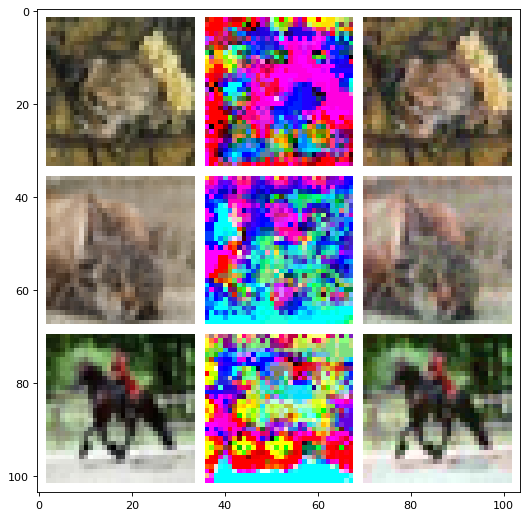

In [9]:
import random
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

def imshow(img):
    fig = plt.figure(figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
def get_pairs_of_imgs(idx):
    clean_img = clean_train_dataset.data[idx]
    unlearnable_img = unlearnable_train_dataset.data[idx]
    clean_img = torchvision.transforms.functional.to_tensor(clean_img)
    unlearnable_img = torchvision.transforms.functional.to_tensor(unlearnable_img)

    x = noise[idx]
    x_min = torch.min(x)
    x_max = torch.max(x)
    noise_norm = (x - x_min) / (x_max - x_min)
    noise_norm = torch.clamp(noise_norm, 0, 1)
    return [clean_img, noise_norm, unlearnable_img]
    
selected_idx = [random.randint(0, 50000) for _ in range(3)]
img_grid = []
for idx in selected_idx:
    img_grid += get_pairs_of_imgs(idx)
    

imshow(torchvision.utils.make_grid(torch.stack(img_grid), nrow=3, pad_value=255))



<h3>Train ResNet18 on Unlearnable Dataset</h3>

In [11]:
from util import AverageMeter

model = ResNet18()
model = model.cuda()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1, weight_decay=0.0005, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30, eta_min=0)

unlearnable_loader = DataLoader(dataset=unlearnable_train_dataset, batch_size=128,
                                shuffle=True, pin_memory=True,
                                drop_last=False, num_workers=6)


for epoch in range(30):
    # Train
    model.train()
    acc_meter = AverageMeter()
    loss_meter = AverageMeter()
    pbar = tqdm(unlearnable_loader, total=len(unlearnable_loader))
    for images, labels in pbar:
        images, labels = images.cuda(), labels.cuda()
        model.zero_grad()
        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()
        
        _, predicted = torch.max(logits.data, 1)
        acc = (predicted == labels).sum().item()/labels.size(0)
        acc_meter.update(acc)
        loss_meter.update(loss.item())
        pbar.set_description("Acc %.2f Loss: %.2f" % (acc_meter.avg*100, loss_meter.avg))
    scheduler.step()
    # Eval
    model.eval()
    correct, total = 0, 0
    for i, (images, labels) in enumerate(clean_test_loader):
        images, labels = images.cuda(), labels.cuda()
        with torch.no_grad():
            logits = model(images)
            _, predicted = torch.max(logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = correct / total
    tqdm.write('Clean Accuracy %.2f\n' % (acc*100))
            

Acc 57.18 Loss: 1.24: 100%|██████████| 391/391 [00:48<00:00,  8.05it/s]


Clean Accuracy 26.83



Acc 83.64 Loss: 0.49: 100%|██████████| 391/391 [00:48<00:00,  8.13it/s]


Clean Accuracy 29.12



Acc 89.76 Loss: 0.31: 100%|██████████| 391/391 [00:48<00:00,  8.13it/s]


Clean Accuracy 27.85



Acc 92.23 Loss: 0.23: 100%|██████████| 391/391 [00:47<00:00,  8.16it/s]


Clean Accuracy 28.56



Acc 93.66 Loss: 0.19: 100%|██████████| 391/391 [00:48<00:00,  8.08it/s]


Clean Accuracy 29.35



Acc 94.26 Loss: 0.17: 100%|██████████| 391/391 [00:48<00:00,  8.14it/s]


Clean Accuracy 29.39



Acc 94.97 Loss: 0.15: 100%|██████████| 391/391 [00:47<00:00,  8.17it/s]


Clean Accuracy 29.78



Acc 95.29 Loss: 0.14: 100%|██████████| 391/391 [00:48<00:00,  8.13it/s]


Clean Accuracy 27.80



Acc 95.79 Loss: 0.13: 100%|██████████| 391/391 [00:48<00:00,  8.13it/s]


Clean Accuracy 28.18



Acc 96.01 Loss: 0.12: 100%|██████████| 391/391 [00:47<00:00,  8.16it/s]


Clean Accuracy 29.33



Acc 96.38 Loss: 0.11: 100%|██████████| 391/391 [00:47<00:00,  8.19it/s]


Clean Accuracy 25.82



Acc 96.45 Loss: 0.11: 100%|██████████| 391/391 [00:47<00:00,  8.20it/s]


Clean Accuracy 28.05



Acc 96.81 Loss: 0.10: 100%|██████████| 391/391 [00:48<00:00,  8.13it/s]


Clean Accuracy 24.59



Acc 96.94 Loss: 0.09: 100%|██████████| 391/391 [00:48<00:00,  8.12it/s]


Clean Accuracy 28.20



Acc 97.18 Loss: 0.09: 100%|██████████| 391/391 [00:48<00:00,  8.12it/s]


Clean Accuracy 25.68



Acc 97.64 Loss: 0.07: 100%|██████████| 391/391 [00:47<00:00,  8.18it/s]


Clean Accuracy 28.12



Acc 97.90 Loss: 0.07: 100%|██████████| 391/391 [00:48<00:00,  8.13it/s]


Clean Accuracy 28.00



Acc 98.16 Loss: 0.06: 100%|██████████| 391/391 [00:47<00:00,  8.17it/s]


Clean Accuracy 29.76



Acc 98.29 Loss: 0.05: 100%|██████████| 391/391 [00:47<00:00,  8.16it/s]


Clean Accuracy 27.59



Acc 98.63 Loss: 0.04: 100%|██████████| 391/391 [00:48<00:00,  8.11it/s]


Clean Accuracy 31.19



Acc 98.82 Loss: 0.04: 100%|██████████| 391/391 [00:48<00:00,  8.08it/s]


Clean Accuracy 31.06



Acc 99.19 Loss: 0.03: 100%|██████████| 391/391 [00:48<00:00,  8.14it/s]


Clean Accuracy 27.90



Acc 99.46 Loss: 0.02: 100%|██████████| 391/391 [00:48<00:00,  8.14it/s]


Clean Accuracy 31.42



Acc 99.62 Loss: 0.01: 100%|██████████| 391/391 [00:48<00:00,  8.14it/s]


Clean Accuracy 30.63



Acc 99.75 Loss: 0.01: 100%|██████████| 391/391 [00:47<00:00,  8.15it/s]


Clean Accuracy 29.63



Acc 99.80 Loss: 0.01: 100%|██████████| 391/391 [00:47<00:00,  8.20it/s]


Clean Accuracy 30.10



Acc 99.85 Loss: 0.01: 100%|██████████| 391/391 [00:47<00:00,  8.18it/s]


Clean Accuracy 30.38



Acc 99.87 Loss: 0.01: 100%|██████████| 391/391 [00:47<00:00,  8.15it/s]


Clean Accuracy 29.47



Acc 99.91 Loss: 0.00: 100%|██████████| 391/391 [00:48<00:00,  8.13it/s]


Clean Accuracy 30.23



Acc 99.91 Loss: 0.00: 100%|██████████| 391/391 [00:34<00:00, 11.46it/s]


Clean Accuracy 30.46

